In [ ]:
from IPython.display import clear_output

In [ ]:
! pip install bio
clear_output()

In [ ]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBList, PDBIO, Select
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка структурного файла комплекса

In [ ]:
pdbl = PDBList()
pdbl.retrieve_pdb_file('1atn', pdir='PDB')
parser = MMCIFParser()
pdb = f'PDB/1atn.cif'
structure = parser.get_structure(f'1atn', pdb)
clear_output()

In [ ]:
# Получение таблицы со всеми атомами комплекса и их координатами, также обозначена, какая это молекула в 'Chain_num', 0 для одного белка, 1 для другого
Atoms_coord_df = pd.DataFrame(columns=['Chain_name', 'Chain_num', 'Residue', 'Type', 'x', 'y', 'z'])
chains = structure[0].get_chains()
num_chain = 0
for chain in chains:
  ch_id = chain.get_id()
  atoms = chain.get_atoms()
  num_chain+=1
  for atom in atoms:
    coord_atom = atom.get_coord()
    name_atom = atom.get_name()
    res_name = str(atom.get_parent())[9:12]
    if atom.get_full_id()[3][0] == ' ':
      Atoms_coord_df.loc[len(Atoms_coord_df.index)] = [ch_id, num_chain-1, res_name, name_atom, round(coord_atom[0]), round(coord_atom[1]), round(coord_atom[2])]
Atoms_coord_df.replace('OXT', 'O', inplace=True)
Atoms_coord_df

,Chain_name,Chain_num,Residue,Type,x,y,z
0,A,0,ASP,N,106,50,42
1,A,0,ASP,CA,106,49,43
2,A,0,ASP,C,107,49,44
3,A,0,ASP,O,107,49,45
4,A,0,ASP,CB,107,47,42
...,...,...,...,...,...,...,...
4926,D,1,THR,O,141,31,98
4927,D,1,THR,CB,139,29,100
4928,D,1,THR,OG1,140,30,101
4929,D,1,THR,CG2,140,28,100


In [ ]:
#Получение центров масс для белков
center_1=[]
x1=0
y1=0
z1=0
k1=0
center_2=[]
x2=0
y2=0
z2=0
k2=0
for j in range(Atoms_coord_df.shape[0]):
  if Atoms_coord_df['Chain_num'][j]==0:
    x1+=Atoms_coord_df['x'][j]
    y1+=Atoms_coord_df['y'][j]
    z1+=Atoms_coord_df['z'][j]
    k1+=1
  elif Atoms_coord_df['Chain_num'][j]==1:
    x2+=Atoms_coord_df['x'][j]
    y2+=Atoms_coord_df['y'][j]
    z2+=Atoms_coord_df['z'][j]
    k2+=1
center_1=[round(x1/k1), round(y1/k1), round(z1/k1)]
center_2=[round(x2/k2), round(y2/k2), round(z2/k2)]

Вектор, соединяющий центры масс молекул

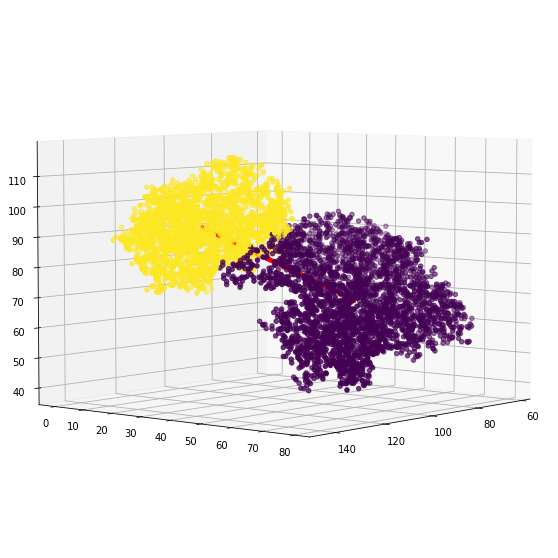

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection="3d")
ax.plot3D([center_1[0],center_2[0]], [center_1[1],center_2[1]], [center_1[2],center_2[2]], 'red', linewidth= 5)
ax.scatter3D(Atoms_coord_df['x'], Atoms_coord_df['y'], Atoms_coord_df['z'], c = Atoms_coord_df['Chain_num'])

ax.view_init(5, 40)
plt.show()

Нахождение разделяющей плоскости с использованием метода логистической регрессии

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(Atoms_coord_df[['x', 'y', 'z']].values, Atoms_coord_df['Chain_num'].astype('int'))

# plane_bind - список коэффициентов [A,B,C,D] в уравнении разделяющей плоскости вида A*x+B*y+C*z+D=0, то есть
plane_bind = list(logreg_clf.coef_[0])
plane_bind.append(logreg_clf.intercept_[0])
print(plane_bind)

[0.27956418632245683, -0.48077161201292673, 0.5244855687004379, -57.64560971216117]


Нахождение пересечения вектора, соединяющего центры масс с разделяющей плоскостью. Полученная точка будет являться центром ячейки

In [ ]:
#Функция для нахождения точки пересечения вектора с плоскостью
def add_v3v3(v0, v1):
    return (
        v0[0] + v1[0],
        v0[1] + v1[1],
        v0[2] + v1[2],
    )


def sub_v3v3(v0, v1):
    return (
        v0[0] - v1[0],
        v0[1] - v1[1],
        v0[2] - v1[2],
    )


def dot_v3v3(v0, v1):
    return (
        (v0[0] * v1[0]) +
        (v0[1] * v1[1]) +
        (v0[2] * v1[2])
    )


def len_squared_v3(v0):
    return dot_v3v3(v0, v0)


def mul_v3_fl(v0, f):
    return (
        v0[0] * f,
        v0[1] * f,
        v0[2] * f,
    )

def isect_line_plane_v3_4d(p0, p1, plane, epsilon=1e-6):
    u = sub_v3v3(p1, p0)
    dot = dot_v3v3(plane, u)

    if abs(dot) > epsilon:
        # Calculate a point on the plane
        # (divide can be omitted for unit hessian-normal form).
        p_co = mul_v3_fl(plane, -plane[3] / len_squared_v3(plane))

        w = sub_v3v3(p0, p_co)
        fac = -dot_v3v3(plane, w) / dot
        u = mul_v3_fl(u, fac)
        return add_v3v3(p0, u)

    return None

In [ ]:
#dot_is - координаты точки пересечения, а следовательно и центра ячейки
dot_is = isect_line_plane_v3_4d(center_1, center_2, plane_bind)


In [ ]:
x0, y0, z0 = dot_is[0], dot_is[1], dot_is[2]
x1, y1, z1 = center_1[0], center_1[1], center_1[2]
x2, y2, z2 = center_2[0], center_2[1], center_2[2]
n_v = [(x1 - x0), (y1 - y0), (z1 - z0)]


Поиск векторов на разделяющей плоскости, нужные для выбора прямоугольной области.

Сначала строим плоскость, параллельную разделяющей на расстоянии 5 А по вектору масс (не является нормалью разделяющей плоскости, но для данной задачи подойдет). Далее выбираем точки, которые находятся близко или на ней, находим точки с наибольшим расстоянием, так получаем вектор. Создаем его проекцию на разделяющую плоскость, ищем параллельный ему, проходящий через центр ячейки. Ищем на нем точки на расстоянии 25 ангстрем от центра плоскости, полученный вектор будет характеризовать наибольшую длину участка связывания.

Следующим шагом находим вектор, перпендикулярный ему на разделяющей плоскости, проходящий через центр ячейки. Ищем на нем точки на расстоянии 25 ангстрем от центра плоскости.
Вместе эти два вектора задают прямоугольную область связывания

In [ ]:
from scipy.optimize import fsolve

#решаем систему уравнений, чтобы найти точку, через которую будет проходить плоскость, параллельная разделяющей на расстоянии 3А по вектору масс
def equations_3(p):
  x,y,z = p
  eq1 = np.sqrt((x0-x)*(x0-x)+(y0-y)*(y0-y) +(z0-z)*(z0-z)) - 3
  eq2 = (x-x1)/n_v[0] - (y-y1)/n_v[1]
  eq3 = (z-z1)/n_v[2] - (y-y1)/n_v[1]
  return (eq1, eq2, eq3)
x, y, z = fsolve(equations_3, (0, 0, 0))
dot_3_1 = [x, y, z]
#Записываем коэффициенты полученной плоскости
bias_3_1 = plane_bind[0]*(-dot_3_1[0]) + plane_bind[1]*(-dot_3_1[1]) + plane_bind[2]*(-dot_3_1[2])
plane_3_1 = [plane_bind[0], plane_bind[1], plane_bind[2], bias_3_1]
plane_3_1

[0.27956418632245683,
 -0.48077161201292673,
 0.5244855687004379,
 -55.4387036296952]

In [ ]:
delta = np.array(dot_3_1) - np.array(dot_is)
dot_3_2= np.array(dot_is)- delta
bias_3_2 = plane_bind[0]*(-dot_3_2[0]) + plane_bind[1]*(-dot_3_2[1]) + plane_bind[2]*(-dot_3_2[2])
plane_3_2 = [plane_bind[0], plane_bind[1], plane_bind[2], bias_3_2]

In [ ]:
#Выбираем атомы, которые примерно лежат на этой плоскости, подставляем их координаты в уравнение плоскости, чтобы понять насколько близко он к ней расположены
Atoms_3A_1 = pd.DataFrame(columns=['Num', 'x', 'y', 'z', 'd'])
for i in range(Atoms_coord_df.shape[0]):
  x = Atoms_coord_df['x'][i]
  y = Atoms_coord_df['y'][i]
  z = Atoms_coord_df['z'][i]
  d = plane_3_1[0]*x + plane_3_1[1]*y + plane_3_1[2]*z + plane_3_1[3]
  if abs(d)<0.2:
    Atoms_3A_1.loc[len(Atoms_3A_1.index)] = [i, x, y, z, d]

Atoms_3A_2 = pd.DataFrame(columns=['Num', 'x', 'y', 'z', 'd'])
for i in range(Atoms_coord_df.shape[0]):
  x = Atoms_coord_df['x'][i]
  y = Atoms_coord_df['y'][i]
  z = Atoms_coord_df['z'][i]
  d = plane_3_2[0]*x + plane_3_2[1]*y + plane_3_2[2]*z + plane_3_2[3]
  if abs(d)<0.3:
    Atoms_3A_2.loc[len(Atoms_3A_2.index)] = [i, x, y, z, d]
if Atoms_3A_2.shape[0]>=Atoms_3A_1.shape[0]:
  Atoms_3A = Atoms_3A_2
else:
  Atoms_3A = Atoms_3A_1

Atoms_3A

,Num,x,y,z,d
0,293.0,122.0,43.0,88.0,-0.264134
1,2996.0,104.0,38.0,93.0,-0.270004
2,3233.0,107.0,35.0,89.0,-0.086939
3,3236.0,108.0,36.0,89.0,-0.288146
4,3237.0,108.0,37.0,90.0,-0.244432
5,3278.0,113.0,41.0,92.0,0.279273
6,3280.0,113.0,39.0,90.0,0.191846
7,3313.0,115.0,47.0,96.0,0.051714
8,3343.0,119.0,49.0,96.0,0.208428
9,3373.0,123.0,51.0,95.0,-0.159344


In [ ]:
from math import sqrt
#Функция для поиска точек с наибольшим расстоянием
def dist(p1, p2):
  x0 = p1[0] - p2[0]
  y0 = p1[1] - p2[1]
  z0 = p1[2] - p2[2]
  return x0 * x0 + y0 * y0 + z0 * z0


def maxDist(p):
  n = p.shape[0]
  maxm = 0
  for i in range(n):
    for j in range(i + 1, n):
      if dist(p.iloc[i], p.iloc[j]) > maxm:
       maxm = dist(p.iloc[i], p.iloc[j])
       max_1 = i
       max_2 = j

  return [max_1, max_2, sqrt(maxm)]


In [ ]:
dots_max_dist = maxDist(Atoms_3A[['x', 'y', 'z']])
dots_max_dist

[9, 23, 43.60045871318328]

In [ ]:
#вектор, соединяющий точки с наибольшим расстоянием
vec_3 = [[Atoms_3A['x'][dots_max_dist[0]] - Atoms_3A['x'][dots_max_dist[1]], Atoms_3A['y'][dots_max_dist[0]] - Atoms_3A['y'][dots_max_dist[1]], Atoms_3A['z'][dots_max_dist[0]] - Atoms_3A['z'][dots_max_dist[1]]]]
vec_3

[[13.0, 34.0, 24.0]]

In [ ]:
# Получение проекции вектора vec_5 на разделяющую плоскость
# vector u
u = np.array(vec_3)

# vector n: n is orthogonal vector to Plane P
n = np.array([plane_bind[0], plane_bind[1], plane_bind[2]])

# Task: Project vector u on Plane P

# finding norm of the vector n
n_norm = np.sqrt(sum(n**2))

# Apply the formula as mentioned above
# for projecting a vector onto the orthogonal vector n
# find dot product using np.dot()
proj_of_u_on_n = (np.dot(u, n)/n_norm**2)*n
proj_vec = u - proj_of_u_on_n
proj_vec = np.reshape(proj_vec, -1)
# subtract proj_of_u_on_n from u:
# this is the projection of u on Plane P
print("Projection of Vector u on Plane Binding is: ", proj_vec)

Projection of Vector u on Plane Binding is:  [13.05943869 33.8977822  24.11151191]


In [ ]:
#Проверяем, лежит ли этот вектор на разделяющей плоскости
proj_vec[0]*plane_bind[0] + proj_vec[1]*plane_bind[1] + proj_vec[2]*plane_bind[2]

0.0

Пробуем повернуть координаты атомов, чтобы разделяющая плоскость бы параллельна плоскости XOY

In [ ]:
#Создаю копию таблицы с атомами
Atoms_coord = Atoms_coord_df.copy()
Atoms_coord

,Chain_name,Chain_num,Residue,Type,x,y,z
0,A,0,ASP,N,106,50,42
1,A,0,ASP,CA,106,49,43
2,A,0,ASP,C,107,49,44
3,A,0,ASP,O,107,49,45
4,A,0,ASP,CB,107,47,42
...,...,...,...,...,...,...,...
4926,D,1,THR,O,141,31,98
4927,D,1,THR,CB,139,29,100
4928,D,1,THR,OG1,140,30,101
4929,D,1,THR,CG2,140,28,100


Вектор нормали можно взять из уравнения плоскости Ax+By+Cx+D=0. Как (A, B, C). см. https://mipt.ru/education/chair/mathematics/upload/ff4/Umnov-AnGeom-i-LinAl-arph0duocc9.pdf Следствие
3.3.1.

In [ ]:
norm = plane_bind[:3]
sum([coor**2 for coor in norm])

0.5843825889666674

Сделаем нормаль единичной

In [ ]:
import math
a = math.sqrt(1/sum([coor**2 for coor in norm]))
norm = [a*coor for coor in norm]
sum([coor**2 for coor in norm])

1.0

In [ ]:
norm = np.array(norm)
norm

array([ 0.36570669, -0.62891244,  0.68609603])

Вектор по которому в нас было большенство связий

In [ ]:
proj_vec

array([13.05943869, 33.8977822 , 24.11151191])

Проверяем, что они ортогональны

In [ ]:
np.dot(norm, proj_vec)

3.552713678800501e-15

Нормируем на 1.

In [ ]:
a = math.sqrt(1/sum([coor**2 for coor in proj_vec]))
proj_vec = a*proj_vec
sum([coor**2 for coor in proj_vec])

1.0

In [ ]:
proj_vec

array([0.29952734, 0.77746929, 0.55301435])

Чтобы найти третий вектор - можно посчитать векторное произведение см https://mipt.ru/education/chair/mathematics/upload/ff4/Umnov-AnGeom-i-LinAl-arph0duocc9.pdf Определение
2.4.2. Найти его сс страницу 67.

In [ ]:
last_vector = np.cross(norm, proj_vec)

 Проверяем ортогональность

In [ ]:
np.dot(proj_vec, norm)

0.0

In [ ]:
np.dot(proj_vec, last_vector)


0.0

In [ ]:
np.dot(norm, last_vector)

5.551115123125783e-17

In [ ]:
sum([coor**2 for coor in last_vector])

1.0

Нормуль)

Итого есть ноавя ортонормированнная система с базисом (proj_vec, last_vector, norm) и центром в точке dot_is

In [ ]:
dot_is

(111.1290062337648, 36.602178489660034, 84.22578331890205)

Для начала совместим центры

In [ ]:
Atoms_coord = Atoms_coord_df.copy()
Atoms_coord

,Chain_name,Chain_num,Residue,Type,x,y,z
0,A,0,ASP,N,106,50,42
1,A,0,ASP,CA,106,49,43
2,A,0,ASP,C,107,49,44
3,A,0,ASP,O,107,49,45
4,A,0,ASP,CB,107,47,42
...,...,...,...,...,...,...,...
4926,D,1,THR,O,141,31,98
4927,D,1,THR,CB,139,29,100
4928,D,1,THR,OG1,140,30,101
4929,D,1,THR,CG2,140,28,100


In [ ]:
Atoms_coord['x'] = Atoms_coord['x']-dot_is[0]
Atoms_coord['y'] = Atoms_coord['y']-dot_is[1]
Atoms_coord['z'] = Atoms_coord['z']-dot_is[2]
Atoms_coord

,Chain_name,Chain_num,Residue,Type,x,y,z
0,A,0,ASP,N,-5.129006,13.397822,-42.225783
1,A,0,ASP,CA,-5.129006,12.397822,-41.225783
2,A,0,ASP,C,-4.129006,12.397822,-40.225783
3,A,0,ASP,O,-4.129006,12.397822,-39.225783
4,A,0,ASP,CB,-4.129006,10.397822,-42.225783
...,...,...,...,...,...,...,...
4926,D,1,THR,O,29.870994,-5.602178,13.774217
4927,D,1,THR,CB,27.870994,-7.602178,15.774217
4928,D,1,THR,OG1,28.870994,-6.602178,16.774217
4929,D,1,THR,CG2,28.870994,-8.602178,15.774217


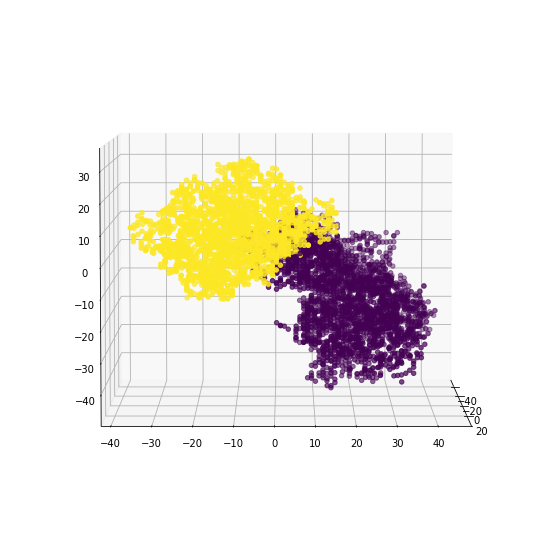

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection="3d")
#ax.plot3D([center_1[0],center_2[0]], [center_1[1],center_2[1]], [center_1[2],center_2[2]], 'red', linewidth= 5)
ax.scatter3D(Atoms_coord['x'], Atoms_coord['y'], Atoms_coord['z'], c = Atoms_coord['Chain_num'])

ax.view_init(5, 0)
plt.show()

Матрица откуда переходим

In [ ]:
print(proj_vec, last_vector, norm)

[0.29952734 0.77746929 0.55301435] [-0.8812162   0.00326347  0.47270219] [ 0.36570669 -0.62891244  0.68609603]


Вектора по столбцам

In [ ]:
from_bazis = np.concatenate((np.expand_dims(proj_vec, axis=1),
                             np.expand_dims(last_vector, axis=1),
                             np.expand_dims(norm, axis=1)
                            ), axis=1)

In [ ]:
from_bazis

array([[ 0.29952734, -0.8812162 ,  0.36570669],
       [ 0.77746929,  0.00326347, -0.62891244],
       [ 0.55301435,  0.47270219,  0.68609603]])

In [ ]:
to_bazis = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])

См задачу 7.5.2.

In [ ]:
s = np.matmul(np.linalg.inv(from_bazis), to_bazis)
s

array([[ 0.29952734,  0.77746929,  0.55301435],
       [-0.8812162 ,  0.00326347,  0.47270219],
       [ 0.36570669, -0.62891244,  0.68609603]])

In [ ]:
x_new = []
y_new = []
z_new = []
for i, item in Atoms_coord.iterrows():
    vec = np.array([[item['x']], [item['y']], [item['z']]])
    new_vec = np.matmul(s, vec)
    x_new.append(new_vec[0][0])
    y_new.append(new_vec[1][0])
    z_new.append(new_vec[2][0])

In [ ]:
Atoms_coord['x_new'] = x_new
Atoms_coord['y_new'] = y_new
Atoms_coord['z_new'] = z_new

In [ ]:
Atoms_coord

,Chain_name,Chain_num,Residue,Type,x,y,z,x_new,y_new,z_new
0,A,0,ASP,N,-5.129006,13.397822,-42.225783,-14.471347,-15.396733,-39.272711
1,A,0,ASP,CA,-5.129006,12.397822,-41.225783,-14.695802,-14.927295,-37.957702
2,A,0,ASP,C,-4.129006,12.397822,-40.225783,-13.843260,-15.335809,-36.905900
3,A,0,ASP,O,-4.129006,12.397822,-39.225783,-13.290246,-14.863106,-36.219804
4,A,0,ASP,CB,-4.129006,10.397822,-42.225783,-16.504228,-16.287740,-37.020267
...,...,...,...,...,...,...,...,...,...,...
4926,D,1,THR,O,29.870994,-5.602178,13.774217,12.208997,-19.829984,23.897737
4927,D,1,THR,CB,27.870994,-7.602178,15.774217,11.161033,-17.128674,25.796341
4928,D,1,THR,OG1,28.870994,-6.602178,16.774217,12.791044,-17.533925,26.219231
4929,D,1,THR,CG2,28.870994,-8.602178,15.774217,10.683091,-18.013154,26.790960


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(Atoms_coord[['x_new', 'y_new', 'z_new']].values, Atoms_coord_df['Chain_num'].astype('int'))

# plane_bind - список коэффициентов [A,B,C,D] в уравнении разделяющей плоскости вида A*x+B*y+C*z+D=0, то есть
plane_bind = list(logreg_clf.coef_[0])
plane_bind.append(logreg_clf.intercept_[0])
print(plane_bind)

[-2.3074185768957473e-06, -2.1657930806938238e-07, 0.7644535614412623, -1.8823884677493232e-05]


In [ ]:
high_v = [[0, 0, -10], [0, 0, 10]]
length_v = [[-25, 0, 0], [25, 0, 0]]
width_v = [[0, -25, 0], [0, 25, 0]]

In [ ]:
high_gr = 10
length_gr = 30
width_gr = 25



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def plot_linear_cube(x, y, z, dx, dy, dz, color='red'):
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {'alpha': 1, 'color': color}
    ax.plot3D(xx, yy, [z]*5, **kwargs)
    ax.plot3D(xx, yy, [z+dz]*5, **kwargs)
    ax.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    ax.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)


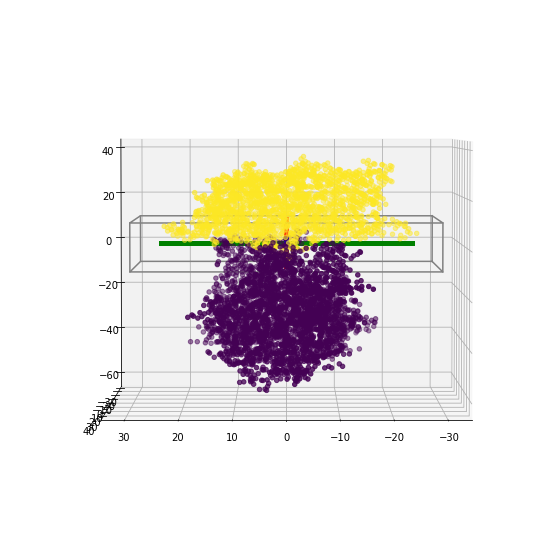

In [ ]:
z = lambda x,y: (-plane_bind[3]-plane_bind[0]*x-plane_bind[1]*y) / plane_bind[2]
tmp_y = np.linspace(-20, 20, 100)
tmp_x = np.linspace(-40, 40, 100)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection="3d")
x,y = np.meshgrid(tmp_x,tmp_y)


#ax.plot_surface(x, y, z(x,y))


ax.plot3D([high_v[0][0],high_v[1][0]], [high_v[0][1],high_v[1][1]], [high_v[0][2],high_v[1][2]], 'red', linewidth= 5)
ax.plot3D([length_v[0][0],length_v[1][0]], [length_v[0][1],length_v[1][1]], [length_v[0][2],length_v[1][2]], 'green', linewidth= 5)
ax.plot3D([width_v[0][0],width_v[1][0]], [width_v[0][1],width_v[1][1]], [width_v[0][2],width_v[1][2]], 'blue', linewidth= 5)
ax.scatter3D(Atoms_coord['x_new'], Atoms_coord['y_new'], Atoms_coord['z_new'], c = Atoms_coord['Chain_num'])
plot_linear_cube(-length_gr, -width_gr, -high_gr, length_gr*2, width_gr*2, high_gr*2, color='gray')

ax.view_init(3, 90)
plt.show()
#plt.savefig('Cell_images/1atn.png')

In [ ]:

Cell_atoms = pd.DataFrame(columns=['Chain_name', 'Chain_num', 'Residue', 'Type', 'x_new', 'y_new', 'z_new'])
for id_atom in range(Atoms_coord.shape[0]):
  at_coord = Atoms_coord.iloc[id_atom]
  if abs(at_coord['x_new'])<= length_gr and abs(at_coord['y_new'])<= width_gr and abs(at_coord['z_new'])<= high_gr:
    x_ind = round(at_coord['x_new']+length_gr)
    y_ind = round(at_coord['y_new']+width_gr)
    z_ind = round(at_coord['z_new']+high_gr)
    Cell_atoms.loc[len(Cell_atoms.index)] = [at_coord['Chain_name'], at_coord['Chain_num'], at_coord['Residue'], at_coord['Type'], x_ind, y_ind, z_ind]



In [ ]:
Cell_atoms

,Chain_name,Chain_num,Residue,Type,x_new,y_new,z_new
0,A,0,ARG,N,39,22,0
1,A,0,ARG,C,41,21,2
2,A,0,ARG,O,41,22,2
3,A,0,PRO,N,40,21,3
4,A,0,PRO,CA,40,21,4
...,...,...,...,...,...,...,...
891,D,1,TRP,CE2,27,6,18
892,D,1,TRP,CE3,27,6,19
893,D,1,TRP,CZ2,27,7,17
894,D,1,TRP,CZ3,27,8,20


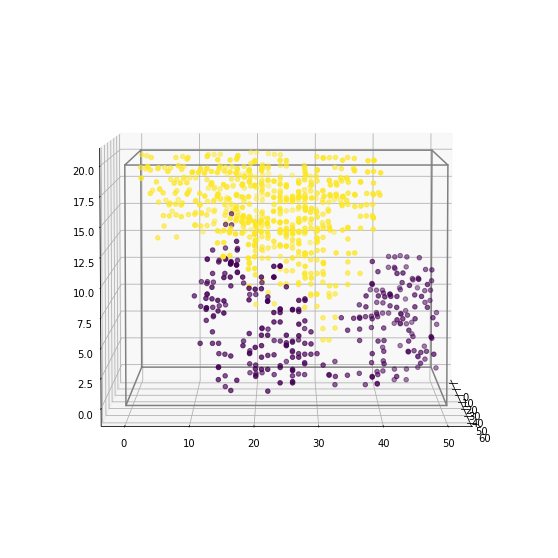

In [ ]:
z = lambda x,y: (-plane_bind[3]-plane_bind[0]*x-plane_bind[1]*y) / plane_bind[2]
tmp_y = np.linspace(-20, 20, 100)
tmp_x = np.linspace(-40, 40, 100)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection="3d")
x,y = np.meshgrid(tmp_x,tmp_y)


#ax.plot_surface(x, y, z(x,y))


#ax.plot3D([high_v[0][0]+length_gr,high_v[1][0]+length_gr], [high_v[0][1]+width_gr,high_v[1][1]+width_gr], [high_v[0][2]+high_gr,high_v[1][2]+high_gr], 'red', linewidth= 5)
#ax.plot3D([length_v[0][0]+length_gr,length_v[1][0]+length_gr], [length_v[0][1]+width_gr,length_v[1][1]+width_gr], [length_v[0][2]+high_gr,length_v[1][2]+high_gr], 'green', linewidth= 5)
#ax.plot3D([width_v[0][0]+length_gr,width_v[1][0]+length_gr], [width_v[0][1]+width_gr,width_v[1][1]+width_gr], [width_v[0][2]+high_gr,width_v[1][2]+high_gr], 'blue', linewidth= 5)
ax.scatter3D(Cell_atoms['x_new'], Cell_atoms['y_new'], Cell_atoms['z_new'], c = Cell_atoms['Chain_num'])

plot_linear_cube(0, 0, 0, length_gr*2, width_gr*2, high_gr*2, color='gray')
ax.view_init(5, 0)
plt.show()

Добавляем каналы, содержащие различные свойства атомов

In [ ]:

# 0: hbond acceptor
# 1: hbond donor
# 2: weak hbond acceptor?
# 3: weak hbond donor
# 4: pos ionisable
# 5: neg ionisable
# 6: hydrophobe
# 7: carbonyl oxygen
# 8: carbonyl carbon
# 9: aromatic


hbond_acceptor = {'ALA': ['O', 'OXT'],
                  'ARG': ['O', 'OXT'],
                  'ASN': ['ND2', 'O', 'OD1', 'OXT'],
                  'ASP': ['OD1', 'OD2', 'O', 'OXT'],
                  'CYS': ['SG', 'O', 'OXT'],
                  'GLN': ['NE2','O', 'OE1', 'OXT'],
                  'GLU': ['OE1', 'OE2', 'O', 'OXT'],
                  'GLY': ['O', 'OXT'],
                  'HIS': ['ND1', 'NE2', 'CE1', 'CD2', 'O', 'OXT'],
                  'ILE': ['O', 'OXT'],
                  'LEU': ['O', 'OXT'],
                  'LYS': ['O', 'OXT'],
                  'MET': ['SD', 'O', 'OXT'],
                  'PHE': ['O', 'OXT'],
                  'PRO': ['O', 'OXT'],
                  'SER': ['OG', 'O', 'OXT'],
                  'THR': ['OG1', 'O', 'OXT'],
                  'TRP': ['O', 'OXT'],
                  'TYR': ['OH', 'O', 'OXT'],
                  'VAL': ['O', 'OXT']}


hbond_donor = {'ALA': ['N'],
                  'ARG': ['N', 'NE', 'NH1', 'NH2'],
                  'ASN': ['N', 'ND2', 'OD1'],
                  'ASP': ['N'],
                  'CYS': ['N', 'SG'],
                  'GLN': ['N', 'NE2', 'OE1'],
                  'GLU': ['N'],
                  'GLY': ['N'],
                  'HIS': ['N', 'ND1', 'CE1', 'NE2', 'CD2'],
                  'ILE': ['N'],
                  'LEU': ['N'],
                  'LYS': ['N', 'NZ'],
                  'MET': ['N'],
                  'PHE': ['N'],
                  'SER': ['N', 'OG'],
                  'THR': ['N', 'OG1'],
                  'TRP': ['N', 'NE1'],
                  'TYR': ['N', 'OH'],
                  'VAL': ['N']}

weak_hbond_acceptor = {'ALA': ['O', 'OXT'],
                  'ARG': ['O', 'OXT'],
                  'ASN': ['O', 'OD1', 'ND2', 'OXT'],
                  'ASP': ['OD1', 'OD2', 'O', 'OXT'],
                  'CYS': ['SG', 'O', 'OXT'],
                  'GLN': ['NE2','O', 'OE1', 'OXT'],
                  'GLU': ['OE1', 'OE2', 'O', 'OXT'],
                  'GLY': ['O', 'OXT'],
                  'HIS': ['ND1', 'NE2', 'CE1', 'CD2', 'O', 'OXT'],
                  'ILE': ['O', 'OXT'],
                  'LEU': ['O', 'OXT'],
                  'LYS': ['O', 'OXT'],
                  'MET': ['SD', 'O', 'OXT'],
                  'PHE': ['O', 'OXT'],
                  'PRO': ['O', 'OXT'],
                  'SER': ['OG', 'O', 'OXT'],
                  'THR': ['OG1', 'O', 'OXT'],
                  'TRP': ['O', 'OXT'],
                  'TYR': ['OH', 'O', 'OXT'],
                  'VAL': ['O', 'OXT']}

weak_hbond_donor = {'ALA': ['CA', 'CB'],
                  'ARG': ['CA', 'CB', 'CG', 'CD'],
                  'ASN': ['CA', 'CB'],
                  'ASP': ['CA', 'CB'],
                  'CYS': ['CA', 'CB'],
                  'GLN': ['CA', 'CB', 'CG'],
                  'GLU': ['CA', 'CB', 'CG'],
                  'GLY': ['CA'],
                  'HIS': ['CA', 'CB'],
                  'ILE': ['CA', 'CB', 'CG1', 'CD1', 'CG2'],
                  'LEU': ['CA', 'CB', 'CG', 'CD1', 'CD2'],
                  'LYS': ['CA', 'CB', 'CG', 'CD', 'CE'],
                  'MET': ['CA', 'CB', 'CG', 'CE'],
                  'PHE': ['CA', 'CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
                  'PRO': ['CA', 'CB', 'CG', 'CD'],
                  'SER': ['CA', 'CB'],
                  'THR': ['CA', 'CB', 'CG2'],
                  'TRP': ['CA', 'CB', 'CD1', 'CE3', 'CZ3', 'CH2', 'CZ2'],
                  'TYR': ['CA', 'CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
                  'VAL': ['CA', 'CB', 'CG1', 'CG2']}

pos_ionisable = {'ARG': ['NE', 'CZ', 'NH1', 'NH2'],
                  'HIS': ['CG', 'ND1', 'CE1', 'NE2', 'CD2'],
                  'LYS': ['NZ']}

neg_ionisable = {'ASP': ['OD1', 'OD2'],
                 'GLU': ['OE1', 'OE2']}

hydrophobe = {'ALA': [ 'CB'],
                  'ARG': ['CB', 'CG'],
                  'ASN': ['CB'],
                  'ASP': ['CB'],
                  'CYS': ['CB'],
                  'GLN': ['CB', 'CG'],
                  'GLU': ['CB', 'CG'],
                  'HIS': ['CB'],
                  'ILE': ['CB', 'CG1', 'CD1', 'CG2'],
                  'LEU': ['CB', 'CG', 'CD1', 'CD2'],
                  'LYS': ['CB', 'CG', 'CD'],
                  'MET': ['CB', 'CG', 'CE', 'SD'],
                  'PHE': ['CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
                  'PRO': ['CB', 'CG'],
                  'THR': ['CG2'],
                  'TRP': ['CB', 'CG', 'CD2', 'CE3', 'CZ3', 'CH2', 'CZ2'],
                  'TYR': ['CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2'],
                  'VAL': ['CB', 'CG1', 'CG2']}

carbonyl_oxygen = {'ALA': ['O'],
                  'ARG': ['O'],
                  'ASN': ['O'],
                  'ASP': ['O'],
                  'CYS': ['O'],
                  'GLN': ['O'],
                  'GLU': ['O'],
                  'GLY': ['O'],
                  'HIS': ['O'],
                  'ILE': ['O'],
                  'LEU': ['O'],
                  'LYS': ['O'],
                  'MET': ['O'],
                  'PHE': ['O'],
                  'PRO': ['O'],
                  'SER': ['O'],
                  'THR': ['O'],
                  'TRP': ['O'],
                  'TYR': ['O'],
                  'VAL': ['O']}

carbonyl_carbon = {'ALA': ['C'],
                  'ARG': ['C'],
                  'ASN': ['C'],
                  'ASP': ['C'],
                  'CYS': ['C'],
                  'GLN': ['C'],
                  'GLU': ['C'],
                  'GLY': ['C'],
                  'HIS': ['C'],
                  'ILE': ['C'],
                  'LEU': ['C'],
                  'LYS': ['C'],
                  'MET': ['C'],
                  'PHE': ['C'],
                  'PRO': ['C'],
                  'SER': ['C'],
                  'THR': ['C'],
                  'TRP': ['C'],
                  'TYR': ['C'],
                  'VAL': ['C']}

aromatic = {'HIS': ['CG', 'ND1', 'CE1', 'NE2', 'CD2'],
            'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
            'TRP': ['CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
            'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']}

In [ ]:
hb_a = []
hb_d = []
w_hb_d = []
pos_charge = []
neg_charge = []
hph = []
carb_o = []
carb_c = []
ar = []
for i in range(Cell_atoms.shape[0]):
  atom_str = Cell_atoms.iloc[i]
  if atom_str['Chain_num']==0:
    arr_item = -1
  else:
    arr_item = 1
  if atom_str['Residue'] in hbond_acceptor and atom_str['Type'] in hbond_acceptor[atom_str['Residue']]:
    acceptor = arr_item
  else:
    acceptor = 0
  hb_a.append(acceptor)

  if atom_str['Residue'] in hbond_donor and atom_str['Type'] in hbond_donor[atom_str['Residue']]:
    donor = arr_item
  else:
    donor = 0
  hb_d.append(donor)

  if atom_str['Residue'] in weak_hbond_donor and atom_str['Type'] in weak_hbond_donor[atom_str['Residue']]:
    wdonor = arr_item
  else:
    wdonor = 0
  w_hb_d.append(wdonor)

  if atom_str['Residue'] in pos_ionisable and atom_str['Type'] in pos_ionisable[atom_str['Residue']]:
    pos = arr_item
  else:
    pos = 0
  pos_charge.append(pos)

  if atom_str['Residue'] in neg_ionisable and atom_str['Type'] in neg_ionisable[atom_str['Residue']]:
    neg = arr_item
  else:
    neg = 0
  neg_charge.append(neg)

  if atom_str['Residue'] in hydrophobe and atom_str['Type'] in hydrophobe[atom_str['Residue']]:
    h = arr_item
  else:
      h = 0
  hph.append(h)

  if atom_str['Type'] == 'O':
    o = arr_item
  else:
    o = 0
  carb_o.append(o)

  if atom_str['Type'] == 'C':
    c = arr_item
  else:
    c = 0
  carb_c.append(c)

  if atom_str['Residue'] in aromatic and atom_str['Type'] in aromatic[atom_str['Residue']]:
    a = arr_item
  else:
    a = 0
  ar.append(a)

Cell_atoms['HBond_acceptor'] = hb_a
Cell_atoms['HBond_donor'] = hb_d
Cell_atoms['Weak_HBond_donor'] = w_hb_d
Cell_atoms['Pos_charge'] = pos_charge
Cell_atoms['Neg_charge'] = neg_charge
Cell_atoms['Hydrophoby'] = hph
Cell_atoms['Carbocsile_o'] = carb_o
Cell_atoms['Carbocsile_c'] = carb_c
Cell_atoms['Aromatic'] = ar

num_channels = 10
coord_array = np.zeros((num_channels, length_gr*2+1, width_gr*2+1, high_gr*2+1))
for a in range(Cell_atoms.shape[0]):
    x = Cell_atoms['x_new'][a]
    y = Cell_atoms['y_new'][a]
    z = Cell_atoms['z_new'][a]
    if Cell_atoms['Chain_num'][a] == 0:
      coord_array[0][x][y][z] = Cell_atoms['HBond_acceptor'][a]
      coord_array[1][x][y][z] = Cell_atoms['HBond_donor'][a]
      coord_array[2][x][y][z] = Cell_atoms['Weak_HBond_donor'][a]
      coord_array[3][x][y][z] = Cell_atoms['HBond_acceptor'][a]
      coord_array[4][x][y][z] = Cell_atoms['Pos_charge'][a]
      coord_array[5][x][y][z] = Cell_atoms['Neg_charge'][a]
      coord_array[6][x][y][z] = Cell_atoms['Hydrophoby'][a]
      coord_array[7][x][y][z] = Cell_atoms['Carbocsile_o'][a]
      coord_array[8][x][y][z] = Cell_atoms['Carbocsile_c'][a]
      coord_array[9][x][y][z] = Cell_atoms['Aromatic'][a]
    else:
      coord_array[0][x][y][z] = Cell_atoms['HBond_donor'][a]
      coord_array[1][x][y][z] = Cell_atoms['HBond_acceptor'][a]
      coord_array[2][x][y][z] = Cell_atoms['HBond_acceptor'][a]
      coord_array[3][x][y][z] = Cell_atoms['Weak_HBond_donor'][a]
      coord_array[4][x][y][z] = Cell_atoms['Neg_charge'][a]
      coord_array[5][x][y][z] = Cell_atoms['Pos_charge'][a]
      coord_array[6][x][y][z] = Cell_atoms['Hydrophoby'][a]
      coord_array[7][x][y][z] = Cell_atoms['Carbocsile_o'][a]
      coord_array[8][x][y][z] = Cell_atoms['Carbocsile_c'][a]
      coord_array[9][x][y][z] = Cell_atoms['Aromatic'][a]


with open(f'drive/MyDrive/Dataset/{struct_id}.npy', 'wb') as f:
  np.save(f, coord_array)
